# Mathematics of Machine Learning

### Hands-on 1: Introduction to Jax, Automatic Differentiation, Flax & co

Filippo Vicentini and Giuseppe Carleo

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/Lectures/blob/master/2301_Pisa/1-jax.ipynb) 

In this hands-on you will learn about Jax, a differentiable-programming framework for Python, and at the end we will be building a simple logistic-regression example.

The program of this Hands-on is the following:

0. Setup
1. Introduction to Jax
2. Automatic differentiation with Jax
3. Linear regression with Jax and Flax

## 0 - Setup

To run this notebook you will need:
 - Python >= 3.7
 - A notebook interface (Jupyter Notebook / Lab or Google Colab)
 - Jax >= 0.2.17
 - Flax >= 0.3
 - Optax >= 0.0.8
 
Some of the next notebooks will also use `tensorflow_datasets` to automatically download and setup Machine-Learning datasets such as MNIST. It requires `tensorflow` to be installed.
 
During the class we will be running this notebook with Google Colab, that gives you an easy to use environment in the Cloud with access to a GPU. Thankfully, Colab has tensorflow already installed.

To install the packages in Colab you need to run the cell below.
*If you are running in your own environment, you should not run the cell below!*

In [ ]:
!pip install --upgrade jax flax optax tqdm sklearn


If you wish to run this notebook or experiment with an environment in your own machine I suggest the following:

 - Install Python with pyenv: https://realpython.com/intro-to-pyenv/ 
 - Install the notebook interface with pip
 - Install the packages with pip

## 1 - Introduction to Jax

In this Notebook I will assume familiarity with basic python constructs, such as defining functions, lists and tuples, printing and importing packages, loops and comprehension. 
If any of this is not clear, please do ask question.

In [1]:
# We start by importing jax
import jax

print(jax.__version__)

0.4.1


Do check the version! You should have a recent version (>= 0.2.18)

### 1.1 - Jax's NumPy API

In [4]:
# import standard numpy
import numpy as np

# import jax.numpy as jnp
import jax.numpy as jnp

`jax.numpy` is the NumPy-like API that needs to be imported, and we will also use `jax.random` to generate some data to work on. 

Let's start by generating some matrices, and then try matrix multiplication.

In [6]:
m = jnp.ones((4,4)) # We're generating one 4 by 4 matrix filled with ones.
n = jnp.array([[1.0, 2.0, 3.0, 4.0],
               [5.0, 6.0, 7.0, 8.0]]) # An explicit 2 by 4 array

Let's try to print one of those objects

In [7]:
m

DeviceArray([[1., 1., 1., 1.],
             [1., 1., 1., 1.],
             [1., 1., 1., 1.],
             [1., 1., 1., 1.]], dtype=float32)

In [8]:
# we can also inspect it's shape, size and dtype
print(f"shape: {m.shape}")
print(f"size: {m.size}")
print(f"dtype: {m.dtype}")

shape: (4, 4)
size: 16
dtype: float32


Arrays in JAX are represented as DeviceArray instances and are agnostic to the place where the array lives (CPU, GPU, or TPU). This is why we're getting the warning that no GPU/TPU was found and JAX is falling back to a CPU (unless you're running it in an environment that has a GPU/TPU available).

We can obviously multiply matrices like we would do in NumPy.

JAX is fully compatible with NumPy, and can transparently process arrays from one library to the other.

In [9]:
x = np.random.normal(size=(4,4)) # Creating one standard NumPy array instance
jnp.dot(x,m)

DeviceArray([[-0.67587173, -0.67587173, -0.67587173, -0.67587173],
             [-1.8554293 , -1.8554293 , -1.8554293 , -1.8554293 ],
             [-0.54560286, -0.54560286, -0.54560286, -0.54560286],
             [-0.23635823, -0.23635823, -0.23635823, -0.23635823]],            dtype=float32)

Using NumPy arrays directly will result in multiple transfers from CPU to GPU/TPU memory. In general, try to work with objects that are all jax's DeviceArrays by converting everything before-hand using `jnp.asarray`.

### 1.2 - (Im)mutability
JAX is functional by essence, one practical consequence being that JAX arrays are immutable. This means no in-place ops and sliced assignments. More generally, functions should not take input or produce output using a global state.

In [11]:
# we construct a matrix
x = jnp.array([[1.0, 2.0, 3.0, 4.0],
               [5.0, 6.0, 7.0, 8.0]])
print("x: \n", x)

x: 
 [[1. 2. 3. 4.]
 [5. 6. 7. 8.]]


In [12]:
# we update some indices
updated = x.at[0,0].set(3.0) # whereas x[0,0] = 3.0 would fail

In [13]:
print("x: \n", x) # Note that x didn't change, no in-place mutation.
print("updated: \n", updated)

x: 
 [[1. 2. 3. 4.]
 [5. 6. 7. 8.]]
updated: 
 [[3. 2. 3. 4.]
 [5. 6. 7. 8.]]


### 1.3 - Managing randomness
In JAX, randomness is managed in a very specific way, and you can read more on JAX's docs [here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#%F0%9F%94%AA-Random-Numbers) (we borrow content from there!). As the JAX team puts it:

*JAX implements an explicit PRNG where entropy production and consumption are handled by explicitly passing and iterating a PRNG state. JAX uses a modern Threefry counter-based PRNG that’s splittable. That is, its design allows us to fork the PRNG state into new PRNGs for use with parallel stochastic generation.*

In short, you need to explicitly manage the PRNGs (pseudo random number generators) and their states. In JAX's PRNGs, the state is represented as a pair of two unsigned-int32s that is called a key (there is no special meaning to the two unsigned int32s -- it's just a way of representing a uint64).

In [20]:
# let's import jax.random
from jax import random

In [21]:
key = random.PRNGKey(12)
key

DeviceArray([ 0, 12], dtype=uint32)

If you use this key multiple times, you'll get the same "random" output each time. To generate further entries in the sequence, you'll need to split the PRNG and thus generate a new pair of keys.

In [22]:
for i in range(3):
    print(f"Printing the random number using key={key} gives:", 
          random.normal(key, shape=(1,)))

Printing the random number using key=[ 0 12] gives: [-0.5135872]
Printing the random number using key=[ 0 12] gives: [-0.5135872]
Printing the random number using key=[ 0 12] gives: [-0.5135872]


In [23]:
print("old key", key, "--> normal", random.normal(key, shape=(1,)))
key, subkey = random.split(key)
print("    \---SPLIT --> new key   ", key, "--> normal", random.normal(key, shape=(1,)) )
print("             \--> new subkey", subkey, "--> normal", random.normal(subkey, shape=(1,)) )

old key [ 0 12] --> normal [-0.5135872]
    \---SPLIT --> new key    [ 407137227 1028236956] --> normal [-1.0230675]
             \--> new subkey [2469535296  588450469] --> normal [0.73592794]


In [24]:
key = random.PRNGKey(0)
for i in range(3):
    key, key1 = random.split(key)
    print(f"Printing the random number using key={key1} gives:", 
          random.normal(key1, shape=(1,)))

Printing the random number using key=[2718843009 1272950319] gives: [-1.2515389]
Printing the random number using key=[1278412471 2182328957] gives: [-0.58665055]
Printing the random number using key=[4104543539 3483300570] gives: [0.48648307]


While this might seem an annoyance, it's extremely useful because if we simply store this 8 bytes we can always reproduce the state of the random number generator later on. 
This is extremely important when performing automatic differentiation.

### 1.4 - Using jax.jit to speed-up your code

JAX runs transparently on the GPU (or CPU, if you don't have one, and TPU coming soon!). However, in the above example, JAX is dispatching kernels from python to the CPU/GPU one operation at a time. 

Dispatching has a considerable overhead of several microseconds. Ideally we would like to pay this cost only once, at the beginning of a `kernel`, by leaving Python-land entirely.

If we have a sequence of operations, we can use the `@jit` decorator to compile multiple operations together using [XLA](https://www.tensorflow.org/xla). 

Effectively, what this does is the following:
 - Your function is executed with a 'tape', where every operation is recorded
 - Calculations are not performed. Instead, on the tape it is simply written down multiply matrix A times matrix B, add vector C, etc... 
    - The tape only knows shapes and dtypes of your vectors.
 - Once the function returns, the 'tape' is converted to code, then optimized, compiled, and your function is replaced by this compiled code.


In [35]:
# let's define a sample function
def my_fun(x):
    div = 1.0 + 1.0
    return jnp.dot(x.T,x)/div

In [36]:
# let's define the inputs
v = jnp.ones(10)
v

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [37]:
# let's try to execute it
my_fun(v)

DeviceArray(5., dtype=float32)

In [38]:
#Let's now try to jit it:
my_jitted_fun = jax.jit(my_fun)
my_jitted_fun

<CompiledFunction of <function my_fun at 0x134c810d0>>

In [39]:
my_jitted_fun(x)

DeviceArray([[13., 16., 19., 22.],
             [16., 20., 24., 28.],
             [19., 24., 29., 34.],
             [22., 28., 34., 40.]], dtype=float32)

In [40]:
my_jitted_fun(x)

DeviceArray([[13., 16., 19., 22.],
             [16., 20., 24., 28.],
             [19., 24., 29., 34.],
             [22., 28., 34., 40.]], dtype=float32)

In [41]:
%%timeit 
my_jitted_fun(v)

3.66 µs ± 271 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [42]:
%%timeit 
my_fun(v)

19.2 µs ± 343 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


We can also inspect the tape:

In [43]:
jax.make_jaxpr(my_fun)(v)

{ lambda ; a:f32[10]. let
    b:f32[] = dot_general[
      dimension_numbers=(((0,), (0,)), ((), ()))
      precision=None
      preferred_element_type=None
    ] a a
    c:f32[] = div b 2.0
  in (c,) }

Remember, the original code was
```python
def my_fun(x):
    div = 1.0 + 1.0
    return jnp.dot(x.T,x)/div
```

But in the Intermediate Representation (IR) or JaxPR (Jax Program Representation) we see no mention of `div = 1+1`.
That is because Jax only detects operations on Jax types, and ignores the others.

## 1.4.1 How jit works internally

Jit, and all other jax program transformations works internally by executing your code with some _mock_ objects: instead of doing operations with arrays containing data, they execute it using some `Tracers`, empty boxes that contain some static data like the array shape and type but don't contain any numerical data.

This is used in order to generate a static representation of the program, which then gets executed very fast with the real data *after* the compilation is terminated.

In [91]:
def my_fun(x):
    print(f"input has shape: {x.shape} and dtype {x.dtype}")
    print(f"{x    = }")
    print(f"{x[1] = }")
    div = 1+1
    print(f"{div  = }")
    y = jnp.dot(x.T,x)/div
    print(f"{y    = }")
    return y

If we execute the non-jitted function, you'll see those print statements printing the arrays:

In [92]:
v = jnp.ones(10)
print(f"{v = }")
print("-------------------")
res = my_fun(v)
print("-------------------")
print(f"{res = }")

v = DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)
-------------------
input has shape: (10,) and dtype float32
x    = DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)
x[1] = DeviceArray(1., dtype=float32)
div  = 2
y    = DeviceArray(5., dtype=float32)
-------------------
res = DeviceArray(5., dtype=float32)


But if we execute a function under `jax.jit` or any other jax transformation, you will see that the arrays are replaced with those empty Tracer that behave like arrays, but they are not.

In [93]:
jfun = jax.jit(my_fun)

v = jnp.ones(10)
print(f"{v = }")
print("--------- First Run ----------")
res = jfun(v)
print("----------End of First Run ---------")
print(f"{res = }")

v = DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)
--------- First Run ----------
input has shape: (10,) and dtype float32
x    = Traced<ShapedArray(float32[10])>with<DynamicJaxprTrace(level=0/1)>
x[1] = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
div  = 2
y    = Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
----------End of First Run ---------
res = DeviceArray(5., dtype=float32)


In [94]:
print("--------- Second Run ----------")
res = jfun(v)
print("----------Second Run ---------")
print(f"{res = }")

--------- Second Run ----------
----------Second Run ---------
res = DeviceArray(5., dtype=float32)


### 1.4.2 Control Flow

This 'abstract evaluation' has consequences when we try to write functions with control flow: we can use in if/else statements quantities that are _statically known_ during the _abstract evaluation_ such as array sizes.

In [97]:
def my_fun_check(x):
    print(f"executing with {x.shape}")
    if x.size > 5:
        return x**2
    else:
        return x**3

In [99]:
jax.make_jaxpr(my_fun_check)(jnp.ones(3))

executing with (3,)


{ lambda ; a:f32[3]. let b:f32[3] = integer_pow[y=3] a in (b,) }

In [ ]:
jax.make_jaxpr(my_fun_check)(jnp.ones(3))

executing with (6,)


{ lambda ; a:f32[6]. let b:f32[6] = integer_pow[y=2] a in (b,) }

But we cannot do use in if/else checks any information that depends on the *content* of the arrays.
Consider for example the function `relu`

In [104]:
def my_relu(x):
    cond = x>0
    print(f"{x    = }")
    print(f"{cond = }")
    if cond:
        return x
    else:
        return 0.0

If we execute it normally with Python everything is a standard *concrete* type:

In [106]:
my_relu(3.0)

x    = 3.0
cond = True


3.0

But if we execute it under a Jax.jit, x will be an empty cotainer so it's impossible to know if $x>0$ or not until the program is actually executed with some data.

In [107]:
jax.make_jaxpr(my_relu)(3)

x    = Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
cond = Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
The problem arose with the `bool` function. 

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In this case we have to use some jax-built-in functions that record into the tap the `if/else` without actually executing it:

In [112]:
def my_good_relu(x):
    print(f"{x    = }")
    cond = x>0
    print(f"{cond = }")
    res = jnp.where(x>0, x, 0)
    print(f"{res  = }")
    return res

In [113]:
jax.make_jaxpr(my_good_relu)(3)

x    = Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
cond = Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
res  = Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>


{ lambda ; a:i32[]. let
    _:bool[] = gt a 0
    b:bool[] = gt a 0
    c:i32[] = xla_call[
      call_jaxpr={ lambda ; d:bool[] e:i32[] f:i32[]. let
          g:i32[] = select_n d f e
        in (g,) }
      name=_where
    ] b a 0
  in (c,) }

### 1.4.3 Loops

Loops have the same problem... we can't loop if we don't have the concrete value:

In [116]:
def my_pow(x, n):
    i = 0
    res = 1.0
    while i < n:
        res = res*x
        i = i+1
    return res

In [117]:
my_pow(2.0, 3)

8.0

In [192]:
jax.jit(my_pow)(2.0, 3)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
While tracing the function my_pow at /var/folders/b2/0d8k0mb93wz6x66qz2c5b3f00000gn/T/ipykernel_6219/499193949.py:1 for jit, this concrete value was not available in Python because it depends on the value of the argument 'n'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [123]:
jpow = jax.jit(my_pow, static_argnames=['n'])

In [134]:
jpow(2.0, 3)

DeviceArray(8., dtype=float32, weak_type=True)

In [139]:
from functools import partial

jax.make_jaxpr(partial(my_pow, n=3))(2.0)

{ lambda ; a:f32[]. let
    b:f32[] = mul a 1.0
    c:f32[] = mul b a
    d:f32[] = mul c a
  in (d,) }

### 1.5 Automatic Vectorization (vmap)

Consider the following simple code that computes the convolution of two one-dimensional vectors:

In [195]:
def convolve(x, w):
  output = []
  for i in range(1, len(x)-1):
    output.append(jnp.dot(x[i-1:i+2], w))
  return jnp.array(output)

In [196]:
x = jnp.arange(5)
w = jnp.array([2., 3., 4.])

convolve(x, w)

DeviceArray([11., 20., 29.], dtype=float32)

Suppose we would like to apply this function to a batch of weights $w$ to a batch of vectors $x$

In [200]:
xs = jnp.stack([x, 2*x])
ws = jnp.stack([w, 2*w])

The most naive option would be to simply loop over the batch in Python:



In [201]:
def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

manually_batched_convolve(xs, ws)

DeviceArray([[ 11.,  20.,  29.],
             [ 44.,  80., 116.]], dtype=float32)

This produces the correct result, however it is not very efficient.

In order to batch the computation efficiently, you would normally have to rewrite the function manually to ensure it is done in vectorized form. This is not particularly difficult to implement, but does involve changing how the function treats indices, axes, and other parts of the input.

For example, we could manually rewrite convolve() to support vectorized computation across the batch dimension as follows

In [202]:
auto_batch_convolve = jax.vmap(convolve)

auto_batch_convolve(xs, ws)

DeviceArray([[ 11.,  20.,  29.],
             [ 44.,  80., 116.]], dtype=float32)

In [203]:
jitted_batch_convolve = jax.jit(auto_batch_convolve)

jitted_batch_convolve(xs, ws)



DeviceArray([[ 11.,  20.,  29.],
             [ 44.,  80., 116.]], dtype=float32)

## 2 - Gradients and autodiff

For a full overview of JAX's automatic differentiation system, you can check the [Autodiff Cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html).

Even though, theoretically, a VJP (Vector-Jacobian product - reverse autodiff) and a JVP (Jacobian-Vector product - forward-mode autodiff) are similar—they compute a product of a Jacobian and a vector—they differ by the computational complexity of the operation. In short, when you have a large number of parameters (hence a wide matrix), a JVP is less efficient computationally than a VJP, and, conversely, a JVP is more efficient when the Jacobian matrix is a tall matrix. You can read more in the JAX [cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#jacobian-vector-products-jvps-aka-forward-mode-autodiff) [notebook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#vector-jacobian-products-vjps-aka-reverse-mode-autodiff) mentioned above.

### 2.1 - Gradients

JAX provides first-class support for gradients and automatic differentiation in functions. This is also where the functional paradigm shines, since gradients on functions are essentially stateless operations. If we consider a simple function $f:\mathbb{R}^n\rightarrow\mathbb{R}$

$$f(x) = \frac{1}{2} x^T x$$

with the (known) gradient:
$$\nabla f(x) = x$$

In [286]:
def f(x):
    return jnp.dot(x.T,x)/2.0

print(v)
v = jnp.ones((4,))
f(v)

[1. 1. 1. 1.]


DeviceArray(2., dtype=float32)

JAX computes the gradient as an operator acting on functions with `jax.grad`. Note that this only works for scalar valued functions.

Let's take the gradient of f and make sure it matches the identity map.

In [289]:
grad_f = jax.grad(f)

In [290]:
print("Gradient of f taken at point v")
print(grad_f(v)) # should be equal to v !

Gradient of f taken at point v
[1. 1. 1. 1.]


We can inspect the tape by using `jax.make_jaxpr(my_function)(input)`.
This substitutes to the inputs equivalent tapes, records every operation, and then
prints it.

In this intermediate representation (IR), every 'variable' is assigned only once and there is only one operation per 'line'.

 - The first line lists the inputs (in this case we have only one input, 'a', which we know is a vector.
 - The second line says that 'b' is obtained by doing `dot_general(a,a)`, which is the generic operation corresponding to dot product
 - The third line says that `c` is obtained by dividing `b` by `2.0`
 - The last line says that `c` should be returned.

In [291]:
jax.make_jaxpr(f)(v)

{ lambda  ; a.
  let b = dot_general[ dimension_numbers=(((0,), (0,)), ((), ()))
                       precision=None
                       preferred_element_type=None ] a a
      c = div b 2.0
  in (c,) }

We can also inspect the IR of the gradient of f, in much the same way.
Grad does backward differentiation, so it first executes the `forward pass` or the function itself, and then _pulls back_ a value of `1.0` with the jacobian of the function.

The first 3 lines are equivalent to the previous function, however, the following lines are interesting.

*They can be thought of as executing the tape backwards by replacing every operation with its adjoint/pullback.*

 - Line 4: (adjoint of c=b/2) take the sensitivity input `1.0` (adjoint of the output) and multiply it by 2. `c=1.0*2`
 - Line 5: `d = c * a`
 - Line 6: `e = c * a`
 - Line 7 : return `d+e`

In [292]:
jax.make_jaxpr(jax.grad(f))(v)

{ lambda  ; a.
  let b = dot_general[ dimension_numbers=(((0,), (0,)), ((), ()))
                       precision=None
                       preferred_element_type=None ] a a
      _ = div b 2.0
      c = div 1.0 2.0
      d = dot_general[ dimension_numbers=(((), ()), ((), ()))
                       precision=None
                       preferred_element_type=None ] c a
      e = dot_general[ dimension_numbers=(((), ()), ((), ()))
                       precision=None
                       preferred_element_type=None ] c a
      f = add_any d e
  in (f,) }

In [293]:
jax.grad(f)(2.0)

DeviceArray(2., dtype=float32)

In [305]:
z = 1.0

@jax.jit
def f(x):
    y = x*x
    return y*z 

In [307]:
z = 2.0
f(1)

DeviceArray(1., dtype=float32, weak_type=True)

## Going deeper
 
Let's assume a more complicated example: consider a variational function $f : \mathbb{R}^M -> \mathbb{R}^N$, which takes as input a set of parameters $W$ and gives out a vector $\vec{v}=\vec{f}(W)$.

Now, given the matrix $A\in \mathbb{R}^N\times\mathbb{R}^N$, assume we want to minimise the loss

$$
\mathcal{L}(W) = \vec{v}^T A \vec{v} = \vec{f}^T(W) A \vec{f}(W)
$$

We can define the Jacobian $\mathbb{R}^M \times \mathbb{R}^N \ni J_{f}|_W = df(W)/dW$ 
The gradient of this function will be 

$$\nabla_W \mathcal{L}(W) = 2 J_f|_W A$$

## 3 - Linear Regression in Jax

Let's implement one of the simplest models using everything we have seen so far: a linear regression. From a set of data points $\{(x_i,y_i), i\in \{1,\ldots, k\}, x_i\in\mathbb{R}^n,y_i\in\mathbb{R}^m\}$, we try to find a set of parameters $W\in \mathcal{M}_{m,n}(\mathbb{R}), b\in\mathbb{R}^m$ such that the function $f_{W,b}(x)=Wx+b$ minimizes the mean squared error:
$$\mathcal{L}(W,b)\rightarrow\frac{1}{k}\sum_{i=1}^{k} \frac{1}{2}\|y_i-f_{W,b}(x_i)\|^2_2$$

(Note: depending on how you cast the regression problem you might end up with different setups. Theoretically we should be minimizing the expectation of the loss wrt to the data distribution, however for the sake of simplicity here we consider only the sampled loss).

In [143]:
from matplotlib import pyplot as plt 

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [144]:
in_dimension = 1
out_dimension = 1

x, y = make_regression(n_samples=100, 
                       n_features=in_dimension, 
                       n_targets=out_dimension, 
                       noise=10)
y = y / jnp.sqrt(jnp.mean(jnp.square(y)))
print(f"x shape is: {x.shape}")
print(f"y shape is: {x.shape}")

x shape is: (100, 1)
y shape is: (100, 1)


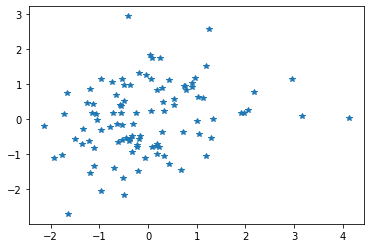

In [145]:
plt.plot(x,y, '*')

In [176]:
# let's try to fit this with a line
params = {
    'z': jnp.zeros(x.shape[1:]),
    'w': jnp.zeros(x.shape[1:]),
    'b': jnp.array(0.)
}

print(params)

def approxfun(params, x):
    return jnp.dot(x, params['w']) + params['b'] + jnp.dot(x**2, params['z'])


{'z': DeviceArray([0.], dtype=float32), 'w': DeviceArray([0.], dtype=float32), 'b': DeviceArray(0., dtype=float32, weak_type=True)}


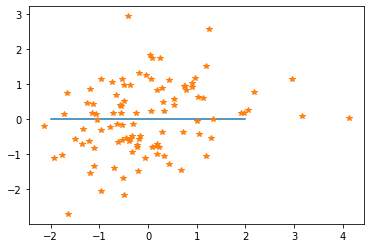

In [177]:
# generate all points in an interval
_xpts = jnp.linspace(-2,2,10)
plt.plot(_xpts, jax.vmap(approxfun, in_axes=(None, 0))(params, _xpts))
plt.plot(x,y, '*')

Let's try to define the function we want to optimise

$$\mathcal{L}(W,b)\rightarrow\frac{1}{k}\sum_{i=1}^{k} \frac{1}{2}\|y_i-f_{W,b}(x_i)\|^2_2$$

In [178]:
def loss_fn(params, xs, ys):
    
    # function returning squared error of a single datapoint
    def squared_error(x,y):
          y_pred = approxfun(params, x)
          return jnp.square(y-y_pred)/2.0
    
    squared_error_vmap = jax.vmap(squared_error)
    return jnp.mean(squared_error_vmap(xs, ys), axis=0)

In [179]:
grad_fn = jax.jit(jax.grad(loss_fn, argnums=0))

In [180]:
# we pick a gradient-descent step size
learning_rate = 0.01

# A list to hold our loss value as a function of iteration
loss_history = []

for _ in range(200):
    loss = loss_fn(params, x, y)
    loss_history.append(loss)

    grads = grad_fn(params, x, y)
    params['w'] = params['w'] - learning_rate * grads['w']
    params['b'] = params['b'] - learning_rate * grads['b']
    params['z'] = params['z'] - learning_rate * grads['z']



Text(0, 0.5, 'Loss value')

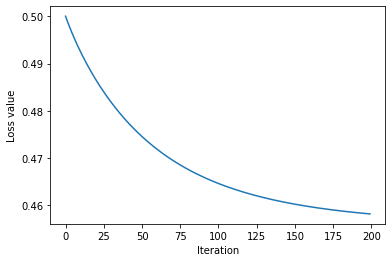

In [181]:
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss value")

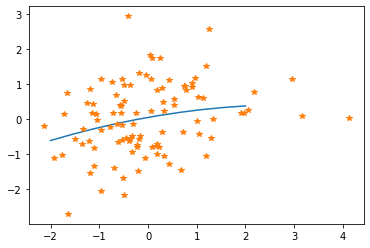

In [182]:
# generate all points in an interval
_xpts = jnp.linspace(-2,2,10)
plt.plot(_xpts, jax.vmap(approxfun, in_axes=(None, 0))(params, _xpts))
plt.plot(x,y, '*')

## 3.1 Interlude: Working with PyTrees

You've seen that we have stored the parameters of our NN into a dictionary with many elements inside

In [183]:
print(params)

{'z': DeviceArray([-0.04163698], dtype=float32), 'w': DeviceArray([0.24668004], dtype=float32), 'b': DeviceArray(0.05511921, dtype=float32, weak_type=True)}


Now, imagine I want to create a copy of those parameters where all are initialized at 0. How do I do that?

In [184]:
params_zero = {'z': jnp.zeros_like(params['z']), 
               'w': jnp.zeros_like(params['w']), 
               'b': jnp.zeros_like(params['b'])}

print(params_zero)

{'z': DeviceArray([0.], dtype=float32), 'w': DeviceArray([0.], dtype=float32), 'b': DeviceArray(0., dtype=float32, weak_type=True)}


But If I now change the structure of my parameters I have to change all my code...
Is there a better way? 

Yes. With a loop?

In [185]:
params_zero = {}
for par_name in params.keys():
    params_zero[par_name] = jnp.zeros_like(params[par_name])
    
print(params_zero)

{'z': DeviceArray([0.], dtype=float32), 'w': DeviceArray([0.], dtype=float32), 'b': DeviceArray(0., dtype=float32, weak_type=True)}


But this changes if we now nest those dictionaries!
Try to run the code above with

In [186]:
params_new = {'layer_0':params}

it will crash.
Jax calls those objects "PyTrees", which are nested dictionaries containing, eventually, arrays.
You can write a code equivalent to the above but that works for all input pytrees.

In [187]:
jax.tree_map(jnp.zeros_like, params)

{'b': DeviceArray(0., dtype=float32, weak_type=True),
 'w': DeviceArray([0.], dtype=float32),
 'z': DeviceArray([0.], dtype=float32)}

And what If I want to sum two sets of parameters? Let's say we have `pars_1` and `pars_2`

In [188]:
pars_1 = jax.tree_map(jnp.zeros_like, params)
pars_2 = jax.tree_map(jnp.ones_like, params)

In [190]:
def oneplustwo(a1,a2):
    return a1+a2

params_1p2 = {}
for par_name in params.keys():
    params_1p2[par_name] = oneplustwo(pars_1[par_name], pars_2[par_name])
    
print(params_1p2)

{'z': DeviceArray([1.], dtype=float32), 'w': DeviceArray([1.], dtype=float32), 'b': DeviceArray(1., dtype=float32, weak_type=True)}


This can be condensed into a much more 'terse' language with the following:

In [191]:
jax.tree_map(oneplustwo, pars_1, pars_2)

{'b': DeviceArray(1., dtype=float32, weak_type=True),
 'w': DeviceArray([1.], dtype=float32),
 'z': DeviceArray([1.], dtype=float32)}

## 3.1 - Linear Regression in Jax with Flax!

In the previous example we had to define by hand the parameters and our _model_.
Once we start using complicated models such as neural networks we don't want to do this by hand, but we want a library to do it for us.

We will be using [Flax](https://github.com/google/flax), which is a Jax-compatible library for doing so.
I chose this one because it is functional and immutable, so it is easier to reason about, however if you prefer object-oriented way-of thinking (😭) you're free to use [Haiku](https://github.com/deepmind/dm-haiku), [objax](https://objax.readthedocs.io) or many others.


In [371]:
import flax.linen as nn

A model in flax is defined as follows.
Take the following as *boilerplate*, there's not much to understand. 
If you want to understand it better and see more advanced features, check out [flax documentation](https://flax.readthedocs.io/en/latest/howtos/model_surgery.html).

$$ D : \mathbb{R}^N \rightarrow \mathbb{R}^M $$

$$ D(x) = W x + b $$

In [213]:
# A Flax model must be a class sub-classing nn.Module
class linear_model(nn.Module):
    
    # The body of the model must be defined using the `@nn.compact` decorator.
    # Just think of it as boilerplate, and if you are curious, check out
    # Flax documentation
    @nn.compact
    def __call__(self, x):
        """
        This function should evaluate the result of the model for an input x and output the prediction.
        """
        x = x.reshape(-1, in_dimension)
        dense_layer = nn.Dense(features=out_dimension)
        return dense_layer(x)

Let's initialize the model:
 
 - We need a seed for the RNG that generates the initial weights
 - We need a sample input

In [378]:
seed = 123

model = linear_model()

key = jax.random.PRNGKey(seed)
sample_input = jnp.ones([1])

pars = model.init(key, sample_input)

We can inspect the parameters.
Flax stores them in a `PyTree`, a tree-structure of nested containers (dictionaries, lists and tuples) where the only leaf-nodes are jax.numpy tensors.

In [379]:
import flax

pars

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-0.34714592]], dtype=float32),
            bias: DeviceArray([0.], dtype=float32),
        },
    },
})

To evaluate the Flax model, we need to use the `model.apply` syntax:

In [380]:
model.apply(pars, x).shape

(100, 1)

So we can rewrite our loss function and training algorithm:

In [381]:
def loss_fn_flax(params, xs, ys):
    
    # function returning squared error of a single datapoint
    def squared_error(x,y):
          y_pred = model.apply(params, x)
          return jnp.square(y-y_pred)/2.0
    
    squared_error_vmap = jax.vmap(squared_error)
    return jnp.mean(squared_error_vmap(xs, ys))

In [382]:
# initialize the network and get initial parameters
pars = model.init(random.PRNGKey(0), x)["params"]

# we pick a gradient-descent step size
learning_rate = 0.5

# A list to hold our loss value as a function of iteration
loss_history = []

# the gradient function
grad_fn = jax.jit(jax.grad(loss_fn_flax))

for _ in range(20):
    loss = loss_fn_flax({"params": pars}, x, y)
    loss_history.append(loss)

    grads = grad_fn({"params": pars}, x, y)["params"]
    pars = jax.tree_multimap(lambda p, g: p - learning_rate * g, pars, grads)

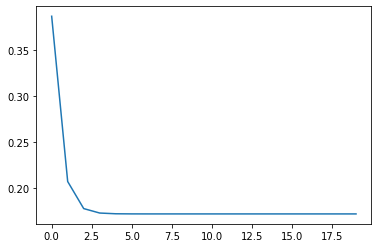

In [383]:
plt.plot(loss_history)

In [221]:
 model.apply({"params": pars}, _xpts)

DeviceArray([[-1.8653626 ],
             [-1.4593016 ],
             [-1.0532407 ],
             [-0.64717937],
             [-0.24111849],
             [ 0.16494268],
             [ 0.57100374],
             [ 0.9770648 ],
             [ 1.3831257 ],
             [ 1.7891867 ]], dtype=float32)

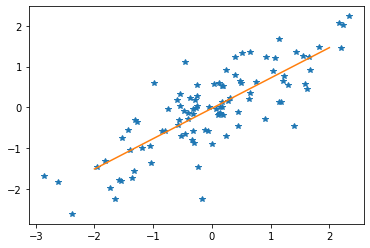

In [384]:
# generate all points in an interval
_xpts = jnp.linspace(-2,2,10)
plt.plot(x,y, '*')
plt.plot(_xpts, model.apply({"params": pars}, _xpts))